# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info[feat_info['attribute'] == 'SOHO_KZ']

,attribute,information_level,type,missing_or_unknown
39,SOHO_KZ,person,categorical,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
missing_feat_info = feat_info[~(feat_info['missing_or_unknown'] == '[]')]
for index , feature in missing_feat_info.iterrows():
    missing = feature['missing_or_unknown'].strip('][').split(',') 
    print(feature.attribute,missing)
    if azdias[feature.attribute].dtype == 'object':
        azdias[feature.attribute] = azdias[feature.attribute].replace(missing , np.nan)
    else:
        for i in missing:
            azdias[feature.attribute] = azdias[feature.attribute].replace(float(i) , np.nan)
            

AGER_TYP ['-1', '0']
ALTERSKATEGORIE_GROB ['-1', '0', '9']
ANREDE_KZ ['-1', '0']
CJT_GESAMTTYP ['0']
FINANZ_MINIMALIST ['-1']
FINANZ_SPARER ['-1']
FINANZ_VORSORGER ['-1']
FINANZ_ANLEGER ['-1']
FINANZ_UNAUFFAELLIGER ['-1']
FINANZ_HAUSBAUER ['-1']
FINANZTYP ['-1']
GEBURTSJAHR ['0']
HEALTH_TYP ['-1', '0']
LP_LEBENSPHASE_FEIN ['0']
LP_LEBENSPHASE_GROB ['0']
LP_FAMILIE_FEIN ['0']
LP_FAMILIE_GROB ['0']
LP_STATUS_FEIN ['0']
LP_STATUS_GROB ['0']
NATIONALITAET_KZ ['-1', '0']
PRAEGENDE_JUGENDJAHRE ['-1', '0']
RETOURTYP_BK_S ['0']
SEMIO_SOZ ['-1', '9']
SEMIO_FAM ['-1', '9']
SEMIO_REL ['-1', '9']
SEMIO_MAT ['-1', '9']
SEMIO_VERT ['-1', '9']
SEMIO_LUST ['-1', '9']
SEMIO_ERL ['-1', '9']
SEMIO_KULT ['-1', '9']
SEMIO_RAT ['-1', '9']
SEMIO_KRIT ['-1', '9']
SEMIO_DOM ['-1', '9']
SEMIO_KAEM ['-1', '9']
SEMIO_PFLICHT ['-1', '9']
SEMIO_TRADV ['-1', '9']
SHOPPER_TYP ['-1']
SOHO_KZ ['-1']
TITEL_KZ ['-1', '0']
VERS_TYP ['-1']
ZABEOTYP ['-1', '9']
ALTER_HH ['0']
HH_EINKOMMEN_SCORE ['-1', '0']
KK_KUNDENTYP ['-1

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_percent = azdias.isnull().mean()

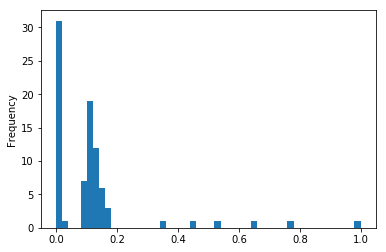

In [9]:
# Investigate patterns in the amount of missing data in each column
null_percent.plot(kind = 'hist',bins = 50)


In [10]:
null_percent.sort_values(ascending=False)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = list(null_percent[null_percent>=0.2].index)
azdias.drop(columns=drop_columns,inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the histogram, we notice a large frequency in columns with zero null values and a large chunk of columns below 0.20% nulls. I considered the columns above 20% null values are outliers

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
row_nulls = azdias.isnull().sum(axis=1)
row_nulls


0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

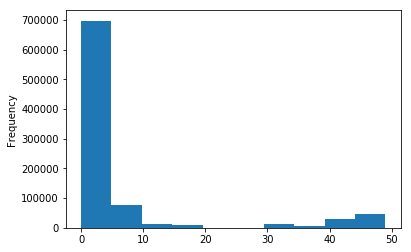

In [13]:
row_nulls.plot(kind='hist')

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
incomplete_data = azdias[row_nulls>20]
azdias = azdias[row_nulls<=20]

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
complete_columns = list(null_percent.sort_values()[:5].index)

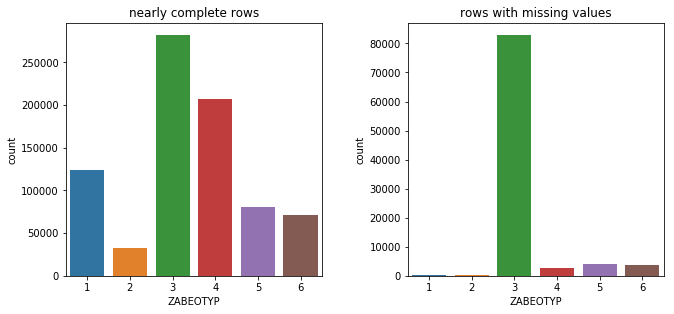

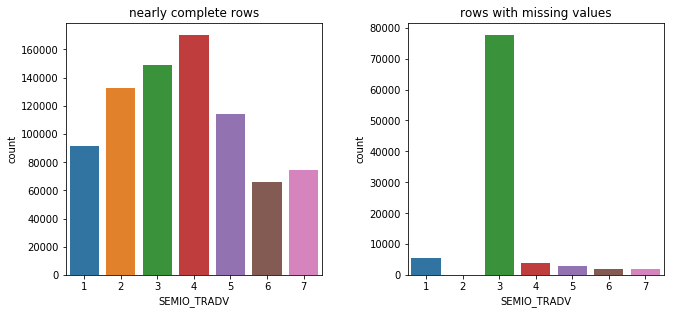

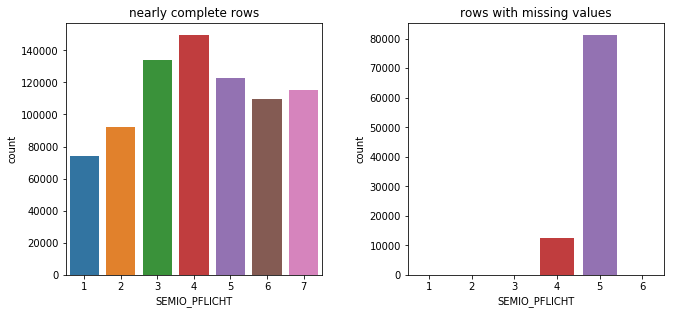

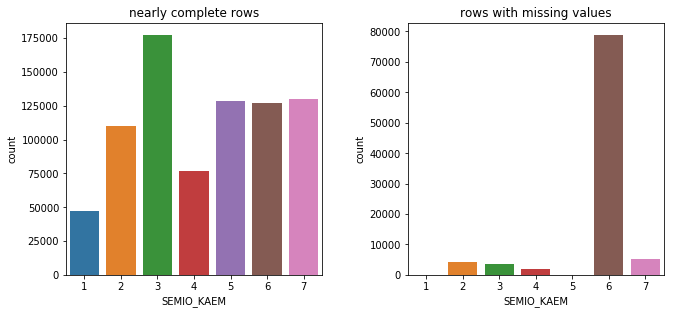

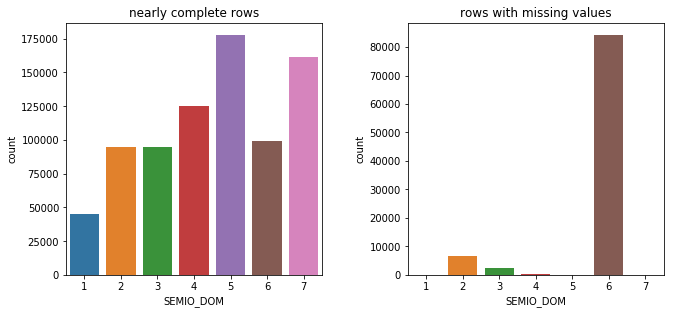

In [16]:
for col in complete_columns:
    fig , ax  = plt.subplots(1,2);
    fig.set_figheight(5)
    fig.set_figwidth(10)
    sns.countplot(azdias[col],ax = ax[0])
    ax[0].title.set_text('nearly complete rows')
    sns.countplot(incomplete_data[col],ax= ax[1])
    ax[1].title.set_text('rows with missing values')
    fig.tight_layout(pad=3.0)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the investigation of the first 5 features with no missing values. the distribution of the values is different in the subset of the data with nearly complete rows and the subset with rows that has missing values. the complete data looks good distributed but the missing data tends to be biassed towards a single value

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_columns = feat_info[feat_info.type == 'categorical']['attribute']
# remove removed columns
cat_columns = cat_columns[~cat_columns.isin(drop_columns)]

In [19]:
#data frame with features information
result = pd.DataFrame(columns=['att','unique_values','number_of_values','null_percent'])
for i , att in enumerate(cat_columns):
    result.loc[i] = [ att, azdias[att].unique() , (~pd.isnull(azdias[att].unique())).sum() ,azdias[att].isnull().mean()*100]
result.sort_values(['number_of_values','null_percent'])

,att,unique_values,number_of_values,null_percent
0,ANREDE_KZ,"[2, 1]",2,0.000000
4,GREEN_AVANTGARDE,"[0, 1]",2,0.000000
11,SOHO_KZ,"[1.0, 0.0]",2,0.000000
15,OST_WEST_KZ,"[W, O]",2,0.000000
12,VERS_TYP,"[2.0, 1.0, nan]",2,4.566819
9,NATIONALITAET_KZ,"[1.0, 3.0, 2.0, nan]",3,4.217695
10,SHOPPER_TYP,"[3.0, 2.0, 1.0, 0.0, nan]",4,4.566819
8,LP_STATUS_GROB,"[1.0, 2.0, 4.0, 5.0, 3.0, nan]",5,0.581120
6,LP_FAMILIE_GROB,"[3.0, 1.0, nan, 5.0, 2.0, 4.0]",5,3.902682
2,FINANZTYP,"[1, 6, 5, 2, 4, 3]",6,0.000000


In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias['OST_WEST_KZ'] =  azdias['OST_WEST_KZ'].replace('W',0).replace('O',1)

In [21]:
drop_columns2 = list(result[result['number_of_values'] >2 ]['att'])

In [22]:
azdias = azdias.drop(columns=drop_columns2)

#### Discussion 1.2.1: Re-Encode Categorical Features
From the summary data frame, I reencoded the feature with the letters to numeric. concerning the other features 
I noticed that they have a lot of unique values that will increase dimensionality  so I decided to drop them

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade_mapper = {1 : 1, 2 :1 ,3:2 ,4:2 ,5:3 , 6:3 , 7 :3 , 8:4 ,9:4 , 10:5 ,11:5 ,12:5 ,13:5,14:6,15:6}
movement_mapper = {1 : 0, 2 :1 ,3:0 ,4:1 ,5:0 , 6:1 , 7 :1 , 8:0 ,9:1 , 10:0 ,11:1 ,12:0 ,13:1,14:0,15:1}
azdias['generation_decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_mapper)
azdias = azdias.drop(columns='PRAEGENDE_JUGENDJAHRE')

In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['wealth'] =  azdias['CAMEO_INTL_2015'].str[0].astype('float64')
azdias['life_stage'] =  azdias['CAMEO_INTL_2015'].str[1].astype('float64')
azdias = azdias.drop(columns='CAMEO_INTL_2015')

#### Discussion 1.2.2: Engineer Mixed-Type Features

here I performed a splitting in these two features into two features each. the first I used a mapper dictionary and in the second I used the string operations

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [26]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
assess = pd.DataFrame(columns=['column' , 'unique_values','data_type'])
for i, col in enumerate(azdias.columns):
    assess.loc[i] = [col , azdias[col].unique() ,azdias[col].dtype ]

In [27]:
pd.set_option('display.max_rows', 100)
assess

,column,unique_values,data_type
0,ALTERSKATEGORIE_GROB,"[1.0, 3.0, 4.0, 2.0, nan]",float64
1,ANREDE_KZ,"[2, 1]",int64
2,FINANZ_MINIMALIST,"[1, 4, 3, 2, 5]",int64
3,FINANZ_SPARER,"[5, 4, 2, 3, 1]",int64
4,FINANZ_VORSORGER,"[2, 1, 5, 4, 3]",int64
5,FINANZ_ANLEGER,"[5, 2, 1, 4, 3]",int64
6,FINANZ_UNAUFFAELLIGER,"[4, 3, 1, 2, 5]",int64
7,FINANZ_HAUSBAUER,"[5, 2, 3, 4, 1]",int64
8,GREEN_AVANTGARDE,"[0, 1]",int64
9,HEALTH_TYP,"[3.0, 2.0, 1.0, nan]",float64


**Every thing looks good**



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_feat_info = feat_info[~(feat_info['missing_or_unknown'] == '[]')]
    for index , feature in missing_feat_info.iterrows():
        missing = feature['missing_or_unknown'].strip('][').split(',') 
        if df[feature.attribute].dtype == 'object':
            df[feature.attribute] = df[feature.attribute].replace(missing , np.nan)
        else:
            for i in missing:
                df[feature.attribute] = df[feature.attribute].replace(float(i) , np.nan)
    
    # remove selected columns and rows, ...
    drop_columns = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df.drop(columns=drop_columns,inplace=True)
    row_nulls = df.isnull().sum(axis=1)
    df = df[row_nulls<=20]
    
    # select, re-encode, and engineer column values.
    #encode binary columns
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].replace('W',0).replace('O',1)
    #remove other columns
    drop_columns2 = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB',
'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df = df.drop(columns=drop_columns2)
    
    decade_mapper = {1 : 1, 2 :1 ,3:2 ,4:2 ,5:3 , 6:3 , 7 :3 , 8:4 ,9:4 , 10:5 ,11:5 ,12:5 ,13:5,14:6,15:6}
    movement_mapper = {1 : 0, 2 :1 ,3:0 ,4:1 ,5:0 , 6:1 , 7 :1 , 8:0 ,9:1 , 10:0 ,11:1 ,12:0 ,13:1,14:0,15:1}
    df['generation_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapper)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapper)
    df = df.drop(columns='PRAEGENDE_JUGENDJAHRE')
    
    df['wealth'] =  df['CAMEO_INTL_2015'].str[0].astype('float64')
    df['life_stage'] =  df['CAMEO_INTL_2015'].str[1].astype('float64')
    df = df.drop(columns='CAMEO_INTL_2015')
    
    # Return the cleaned dataframe.
    return df
    

In [30]:
#testing function
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')
azdias_test = clean_data(azdias_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
azdias_test.shape == azdias.shape

True

In [32]:
(azdias_test.columns == azdias.columns).all()

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#percent of rows kept after dropping nulls
len(azdias.dropna()) / len(azdias)


0.781525809291395

In [34]:
#remove NAN values
azdias = azdias.dropna()

In [35]:
#keep column names for latter
col_names = azdias.columns

In [36]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias)
azdias = scaler.transform(azdias)


### Discussion 2.1: Apply Feature Scaling

The percent of data that remains after dropping nulls is 78% it is good. And also if I filled the null values with one value like the mean or median it will affect the results. So, I decided to drop them.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

0     0.177786
1     0.308730
2     0.399728
3     0.456381
4     0.497450
5     0.529996
6     0.560759
7     0.586672
8     0.609400
9     0.630271
10    0.649879
11    0.668780
12    0.686636
13    0.702468
14    0.717827
15    0.732530
16    0.746849
17    0.760397
18    0.773126
19    0.785313
20    0.797190
21    0.808442
22    0.819366
23    0.829805
24    0.839985
25    0.849256
26    0.857553
27    0.864972
28    0.872310
29    0.879506
30    0.886337
31    0.892983
32    0.899233
33    0.905190
34    0.910977
35    0.916605
36    0.922140
37    0.927133
38    0.931509
39    0.935675
40    0.939684
41    0.943587
42    0.947308
43    0.950921
44    0.954397
45    0.957752
46    0.961061
47    0.964127
48    0.967120
49    0.970040
50    0.972813
51    0.975450
52    0.977926
53    0.980316
54    0.982590
55    0.984728
56    0.986812
57    0.988863
58    0.990841
59    0.992606
60    0.994201
61    0.995722
62    0.996978
63    0.998175
64    0.999328
65    0.999900
66    1.00

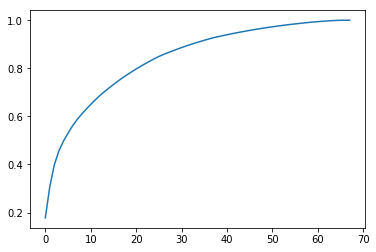

In [38]:
# Investigate the variance accounted for by each principal component.
var_ratio = pd.Series(pca.explained_variance_ratio_)
print(var_ratio.cumsum())
var_ratio.cumsum().plot()

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30)
pca.fit(azdias)
azdias = pca.transform(azdias)


In [40]:
azdias.shape

(623209, 30)

### Discussion 2.2: Perform Dimensionality Reduction

From the graph, the amount of variance explained by each new component after 30 components is small. So, I decided that 30 components will be enough to explain the data as it explains 88% of variance in data

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_weights(pca_model,i):
    '''
    prints a sorted pandas series with the index of column name 
    and values of the weights  of the i-th (zero-based) principle component
    '''
    return pd.Series(pca_model.components_[i],index=col_names).sort_values()

In [42]:
get_weights(pca ,0 )

MOBI_REGIO              -0.232287
PLZ8_ANTG1              -0.217817
KBA05_ANTG1             -0.216948
KBA05_GBZ               -0.207560
FINANZ_MINIMALIST       -0.205518
PLZ8_GBZ                -0.165130
KONSUMNAEHE             -0.158296
INNENSTADT              -0.156459
LP_LEBENSPHASE_FEIN     -0.146009
LP_LEBENSPHASE_GROB     -0.130554
life_stage              -0.120739
BALLRAUM                -0.118664
ALTERSKATEGORIE_GROB    -0.113736
GEBAEUDETYP_RASTER      -0.112502
GREEN_AVANTGARDE        -0.110480
movement                -0.110480
FINANZ_VORSORGER        -0.106999
ANZ_PERSONEN            -0.095428
SEMIO_LUST              -0.082127
KBA13_ANZAHL_PKW        -0.079797
SEMIO_ERL               -0.078522
WOHNLAGE                -0.076584
WOHNDAUER_2008          -0.063767
ONLINE_AFFINITAET       -0.045801
MIN_GEBAEUDEJAHR        -0.035351
SEMIO_VERT              -0.027738
RETOURTYP_BK_S          -0.018416
ANZ_TITEL               -0.005020
SOHO_KZ                 -0.002361
ANREDE_KZ     

In [43]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(pca ,1 )


SEMIO_REL               -0.265356
generation_decade       -0.251799
SEMIO_PFLICHT           -0.241296
FINANZ_SPARER           -0.238544
SEMIO_TRADV             -0.232338
FINANZ_UNAUFFAELLIGER   -0.226688
SEMIO_KULT              -0.219627
FINANZ_ANLEGER          -0.205941
SEMIO_FAM               -0.180114
SEMIO_RAT               -0.175837
ONLINE_AFFINITAET       -0.158623
SEMIO_MAT               -0.157052
SEMIO_SOZ               -0.102347
PLZ8_ANTG1              -0.084391
MOBI_REGIO              -0.078624
KBA05_GBZ               -0.078403
KBA05_ANTG1             -0.071146
INNENSTADT              -0.069620
PLZ8_GBZ                -0.068022
ANZ_PERSONEN            -0.063762
SEMIO_VERT              -0.063223
KONSUMNAEHE             -0.060447
BALLRAUM                -0.056204
HEALTH_TYP              -0.053303
WOHNLAGE                -0.052863
LP_LEBENSPHASE_GROB     -0.043601
GEBAEUDETYP_RASTER      -0.037219
LP_LEBENSPHASE_FEIN     -0.036812
KBA13_ANZAHL_PKW        -0.034260
MIN_GEBAEUDEJA

In [44]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_weights(pca ,2)

ANREDE_KZ               -0.367994
SEMIO_KAEM              -0.338075
SEMIO_DOM               -0.311916
SEMIO_KRIT              -0.270772
SEMIO_RAT               -0.217335
FINANZ_ANLEGER          -0.187431
SEMIO_ERL               -0.171527
generation_decade       -0.104954
FINANZ_SPARER           -0.100549
FINANZ_UNAUFFAELLIGER   -0.089728
SEMIO_TRADV             -0.083819
SEMIO_PFLICHT           -0.075301
FINANZ_HAUSBAUER        -0.054401
ONLINE_AFFINITAET       -0.049134
INNENSTADT              -0.042665
PLZ8_ANTG1              -0.041128
KONSUMNAEHE             -0.036320
BALLRAUM                -0.035623
HH_EINKOMMEN_SCORE      -0.035038
PLZ8_GBZ                -0.033978
GEBAEUDETYP_RASTER      -0.029222
WOHNLAGE                -0.024874
MOBI_REGIO              -0.022756
KKK                     -0.020635
KBA05_GBZ               -0.020589
KBA13_ANZAHL_PKW        -0.020051
KBA05_ANTG1             -0.015575
KBA05_ANTG2             -0.012871
HEALTH_TYP              -0.010689
MIN_GEBAEUDEJA

### Discussion 2.3: Interpret Principal Components

From the analysis of the weights of the first principal components.WE notice a justified positive correlation between PLZ8_ANTG1 and KBA05_ANTG1 as they both have high negative weights the details of the features are :

- PLZ8_ANTG1 : Number of 1-2 family houses in the PLZ8 region
- KBA05_ANTG1 : Number of 1-2 family houses in the microcell

and we notice a negative correlation between PLZ8_ANTG1 and PLZ8_ANTG3 as they both have high weights with different signs. the details of the features are :
- PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region

it is justified that as the share of 1-2 family houses increases the share of 6-10 family houses decreases.

--------------------------------------------------------------------------------------------------------------
From the analysis of the weights of the second principal components.WE notice a justified positive correlation between generation_decade and SEMIO_REL as they both have high negative weights the details of the features are :

 - SEMIO_REL : religious Personality typology
 
it looks like the older generation is more religious than the younger generation.

and we notice a negative correlation between ALTERSKATEGORIE_GROB and generation_decade as they both have high weights with different signs. the details of the features are :

- ALTERSKATEGORIE_GROB : Estimated age based on given name analysis

obviously, the older generation will have high age

------------------------------------------------------------------------------------------
From the analysis of the weights of the third principal components.WE notice a justified positive correlation between SEMIO_KAEM and ANREDE_KZ as they both have high negative weights the details of the features are :

- SEMIO_KAEM : combative attitude
- ANREDE_KZ : gender

looks like males are more combative than females

and we notice a negative correlation between SEMIO_VERT and ANREDE_KZ as they both have high weights with different signs. the details of the features are :

- SEMIO_VERT : social-minded

looks like females are more social-minded than males


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
# Over a number of different cluster counts...
results = pd.Series()
for n in range(10,30,2):
    k_means_model = KMeans(n_clusters=n,random_state=0).fit(azdias)
    score_value = k_means_model.score(azdias)
    print(n , np.abs(score_value)/azdias.shape[0])
    results.loc[n] = np.abs(score_value)/azdias.shape[0]

    

10 35.8350914593
12 34.3346992664
14 33.3779668777
16 32.7127748169
18 32.0219958484
20 30.9504372708
22 30.8440270565
24 29.7517746914
26 29.2520814848
28 28.8400589564


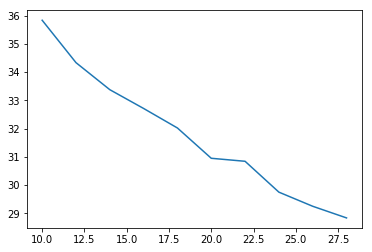

In [64]:
results.plot()

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_means_model = KMeans(n_clusters=20 , random_state= 0).fit(azdias)
clusters = k_means_model.predict(azdias)


In [46]:
clusters.shape

(623209,)

### Discussion 3.1: Apply Clustering to General Population

from the scree plot, I noticed that the best value for the number of clustering is 20 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [48]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [49]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers  = clean_data(customers)
customers = customers.dropna()
customers = scaler.transform(customers)
customers = pca.transform(customers)
customer_clusters = k_means_model.predict(customers)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
customer_clusters.shape

(115643,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [78]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
pop_clusters = pd.Series(clusters).value_counts().sort_index()*100/len(clusters)
cust_clusters = pd.Series(customer_clusters).value_counts().sort_index()*100/len(customer_clusters)
result_df  = pd.concat([pd.DataFrame(pop_clusters),cust_clusters],axis=1)
result_df.columns = ['population%','customer%']

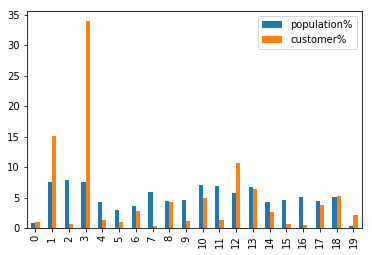

In [79]:
result_df.plot(kind='bar')

In [106]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
original_data = scaler.inverse_transform(pca.inverse_transform(azdias[np.where(clusters == 3)[0]]))
df_cus = pd.DataFrame(original_data,columns=col_names)
df_cus.mean()

ALTERSKATEGORIE_GROB        3.320562
ANREDE_KZ                   1.048144
FINANZ_MINIMALIST           4.868293
FINANZ_SPARER               1.572369
FINANZ_VORSORGER            4.248970
FINANZ_ANLEGER              1.423421
FINANZ_UNAUFFAELLIGER       2.086740
FINANZ_HAUSBAUER            1.917334
GREEN_AVANTGARDE            0.959781
HEALTH_TYP                  2.035323
LP_LEBENSPHASE_FEIN        25.086424
LP_LEBENSPHASE_GROB         7.292211
RETOURTYP_BK_S              4.006311
SEMIO_SOZ                   4.906833
SEMIO_FAM                   4.808686
SEMIO_REL                   3.742678
SEMIO_MAT                   3.844485
SEMIO_VERT                  6.222334
SEMIO_LUST                  5.357862
SEMIO_ERL                   4.108126
SEMIO_KULT                  4.933519
SEMIO_RAT                   2.665672
SEMIO_KRIT                  3.098997
SEMIO_DOM                   3.383516
SEMIO_KAEM                  2.567004
SEMIO_PFLICHT               3.151841
SEMIO_TRADV                 3.110514
S

In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
original_data = scaler.inverse_transform(pca.inverse_transform(azdias[np.where(clusters == 2)[0]]))
df_not_cus = pd.DataFrame(original_data,columns=col_names)
df_not_cus.mean()


ALTERSKATEGORIE_GROB        1.743195
ANREDE_KZ                   0.950250
FINANZ_MINIMALIST           1.854364
FINANZ_SPARER               4.382925
FINANZ_VORSORGER            2.071845
FINANZ_ANLEGER              3.545697
FINANZ_UNAUFFAELLIGER       3.786498
FINANZ_HAUSBAUER            3.662350
GREEN_AVANTGARDE            0.130778
HEALTH_TYP                  2.347113
LP_LEBENSPHASE_FEIN         8.834261
LP_LEBENSPHASE_GROB         2.972356
RETOURTYP_BK_S              2.725819
SEMIO_SOZ                   6.881966
SEMIO_FAM                   6.805979
SEMIO_REL                   6.359518
SEMIO_MAT                   5.140101
SEMIO_VERT                  6.100181
SEMIO_LUST                  2.764704
SEMIO_ERL                   2.001677
SEMIO_KULT                  7.011362
SEMIO_RAT                   4.165145
SEMIO_KRIT                  2.695471
SEMIO_DOM                   2.744356
SEMIO_KAEM                  2.320819
SEMIO_PFLICHT               5.836325
SEMIO_TRADV                 4.962698
S

In [109]:
compare = pd.concat([df_cus.mean(),df_not_cus.mean()],axis=1)
compare.columns = ['customers','not_customers']
compare['diff_per'] = np.abs((compare['not_customers'] - compare['customers']) / compare['customers'])
compare.sort_values('diff_per',ascending=False).head(10)

,customers,not_customers,diff_per
KBA05_ANTG4,0.011309,0.565254,48.982066
KBA05_ANTG3,0.073650,1.244356,15.895489
ANZ_TITEL,0.000033,0.000411,11.541995
ANZ_HAUSHALTE_AKTIV,1.795420,14.079203,6.841733
ANZ_HH_TITEL,0.007187,0.040394,4.620575
PLZ8_ANTG4,0.377465,1.301187,2.447171
SOHO_KZ,0.000025,-0.000031,2.246258
OST_WEST_KZ,0.100017,0.310346,2.102941
FINANZ_SPARER,1.572369,4.382925,1.787465
PLZ8_BAUMAX,1.225089,3.180067,1.595786


### Discussion 3.3: Compare Customer Data to Demographics Data

In this analysis, we noticed that in cluster 3 the customer proportion is larger than the population proportion. and that suggests that people in this cluster are potential customers.

also, we notice that in cluster 2 the customer proportion is less than the population proportion. and that suggests that people in this cluster are not likely to be customers

from the comparison, we notice that:

- from features KBA05_ANTG3 and KBA05_ANTG4 : the Number of 6-10 family houses in the microcell for customers tends to go be zero and are larger than zero for not_customers
- from feature ANZ_HAUSHALTE_AKTIV : Number of households in the building for customers tends to be small and high in not_customers
- from feature FINANZ_SPARER : money-saver in customers tends to high and low in not customers
- from feature PLZ8_BAUMAX : Most common building type within the PLZ8 region fro customers is 1-2 family homes and for not customers mainly 6-10 family homes

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.